In [2]:
# -*- coding: utf-8 -*-
import numpy as np
import pickle
import matplotlib.pyplot as plt
import pandas as pd
import math
from scipy.stats import binom
import scipy.stats as st

In [8]:
seed = 25092525
design_list = ['Erdos-Renyi', 'Probabilistic Expander', 'Random Regular', 'K Chain']
marker_list = {'Erdos-Renyi': 's', 'Probabilistic Expander': 'x', 'Random Regular': 'd', 'K Chain': '*'}
label_list = {'Erdos-Renyi': 'Erdős-Rényi', 'Probabilistic Expander': 'Probabilistic Expander', 'Random Regular': r'Random $d$-Regular', 'K Chain': r'$K$-Chain'}
color_list = {'Erdos-Renyi': 'C0', 'Probabilistic Expander': 'C1', 'Random Regular': 'C3', 'K Chain': 'C2'}
n_list = [100, 200, 300, 400, 500]
p_list = [0.8, 0.5, 0.25]

In [9]:
def prob_binom_geq(n, d, p):
    m = n - d            # number of trials
    k = math.ceil(n * p) # threshold
    if k > m:            # impossible case
        return 0.0
    return binom.sf(k-1, m, p)  # survival function: P[X >= k]

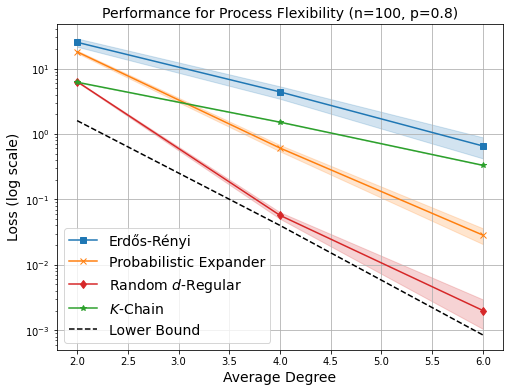

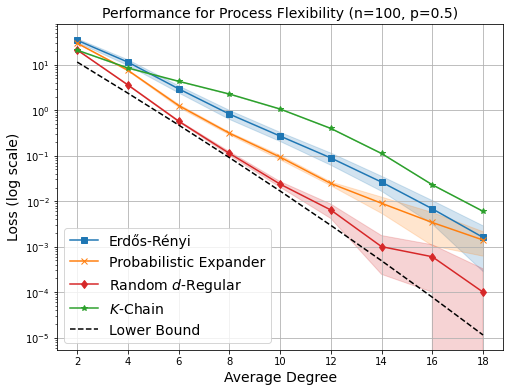

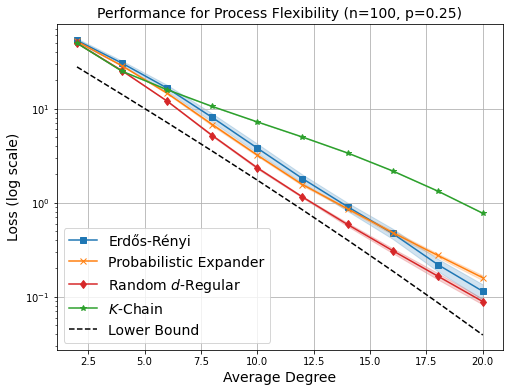

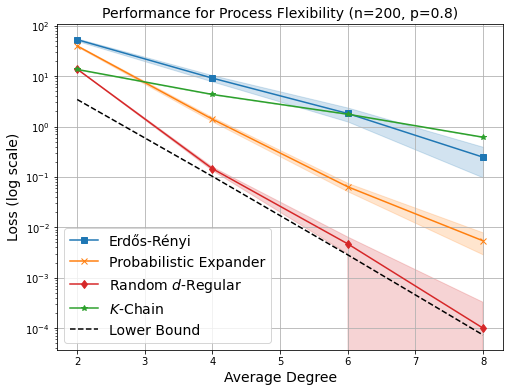

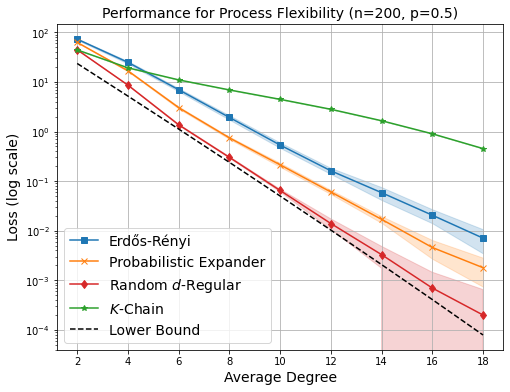

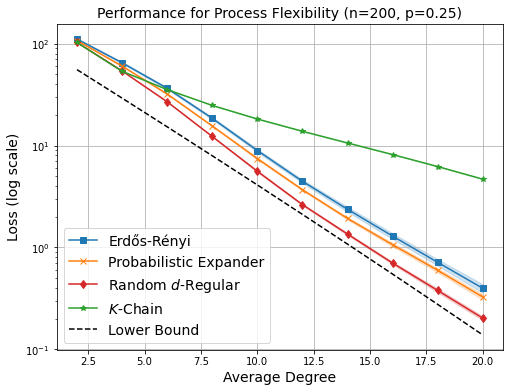

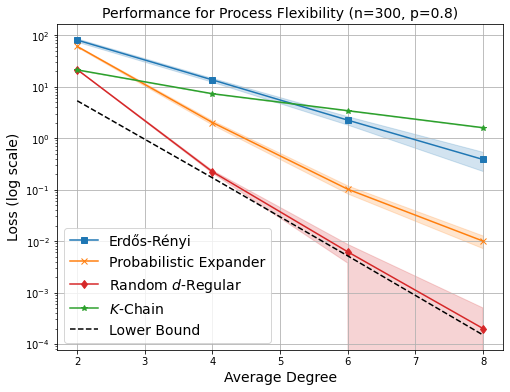

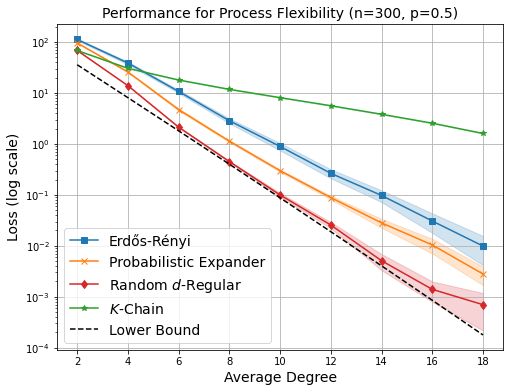

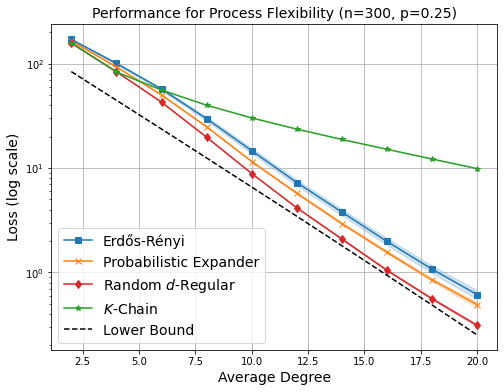

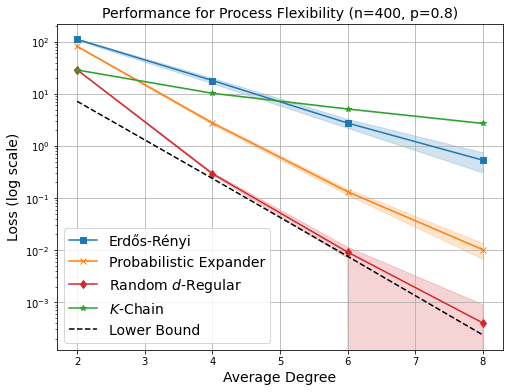

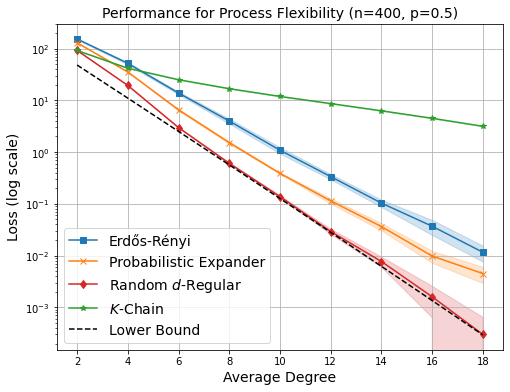

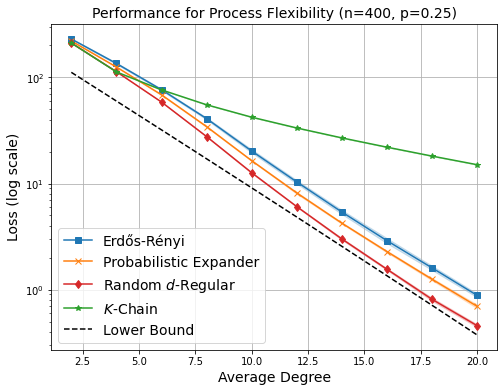

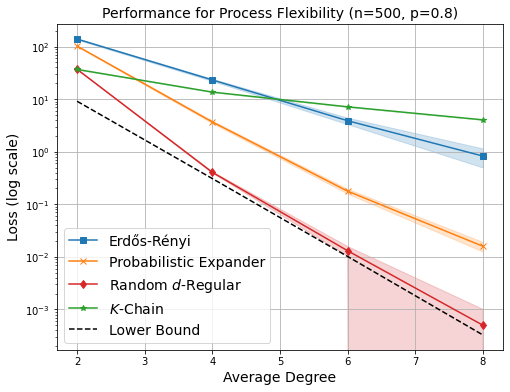

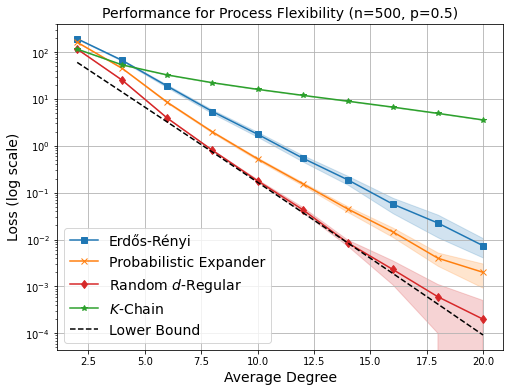

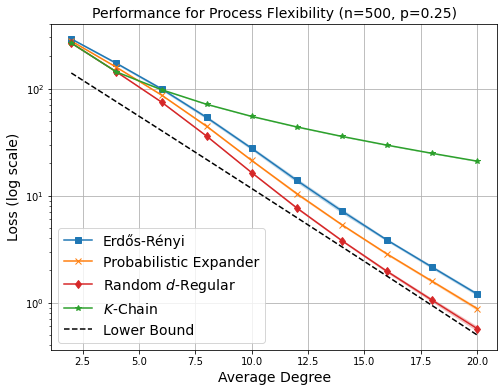

In [10]:
for n in n_list:
    for p in p_list:

        with open(f"results/fix_n_p_results/n_{n}_p_{p}_seed_{seed}.pkl", "rb") as f:
            results = pickle.load(f)

        d_max_1 = int(np.ceil(np.log(1e-5/(n*p))/np.log(1-p)))
        d_max_2 = d_max_1
        d_list_1 = list(range(2, min(d_max_1, 21), 2))
        
        plt.figure(figsize=(8,6))
        for name in design_list:
            for d in d_list_1:
                if np.mean(results[name][d]) == 0: # Whenever a curve reaches 0, we stop plotting the log
                    d_max_2 = min(d, d_max_2)
                    break
        d_list = list(range(2, min(d_max_1, d_max_2, 21), 2))

        loss = {}
        for name in design_list:
            loss[name] = []
            for d in d_list:
                res_mean = np.mean(results[name][d])
                if name != 'K Chain':
                    res_st = st.sem(results[name][d])
                    ci_low, ci_up = st.t.interval(0.95, len(results[name][d])-1, loc=res_mean, scale=res_st)
                else:
                    ci_low, ci_up = res_mean, res_mean
                loss[name].append((res_mean, ci_low, ci_up))

            plt.plot(d_list, [x[0] for x in loss[name]], label=label_list[name], marker=marker_list[name], color=color_list[name])
            plt.fill_between(d_list, [x[1] for x in loss[name]], [x[2] for x in loss[name]], alpha=0.2, color=color_list[name])

        # plot the lower bound
        c = {d: prob_binom_geq(n, d, p) for d in d_list}
        lower_bound = [n*c[d]*(1-p)**d for d in d_list]
        plt.plot(d_list, lower_bound, label=r'Lower Bound', linestyle='--', color='black')
        
        # lower_bound_er = [n*p*np.exp(-p*d) for d in d_list]
        #plt.plot(d_list, np.log(lower_bound_er), label=r'$np\exp(-(1-q)d)$', linestyle='--', color='c')
        
        plt.yscale("log")
        plt.xlabel("Average Degree", fontsize=14)
        plt.ylabel("Loss (log scale)", fontsize=14)
        plt.title(f"Performance for Process Flexibility (n={n}, p={p})", fontsize=14)
        plt.legend(fontsize=14)
        plt.grid(True)
        plt.savefig(f"results/fix_n_p_results/plots/n_{n}_p_{p}.pdf")